In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle

from Bio import SeqIO

import numpy as np
import glob,os

from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

typeface='Arial'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

base_path='/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/'

import colorsys
#### code stolen from seaborn to desaturate colours
def desaturate(color, prop):
    """Decrease the saturation channel of a color by some percent.
    Parameters
    ----------
    color : matplotlib color
        hex, rgb-tuple, or html color name
    prop : float
        saturation channel of color will be multiplied by this value
    Returns
    -------
    new_color : rgb tuple
        desaturated color code in RGB tuple representation
    """
    # Check inputs
    if not 0 <= prop <= 1:
        raise ValueError("prop must be between 0 and 1")

    # Get rgb tuple rep
    rgb = mpl.colors.colorConverter.to_rgb(color)

    # Convert to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # Desaturate the saturation channel
    s *= prop

    # Convert back to rgb
    new_color = colorsys.hls_to_rgb(h, l, s)

    return new_color

def percent2dissim(matrix):
    convert=lambda percent: 1.0-(percent/100.0)
    
    for i,row in enumerate(matrix):
        for j,value in enumerate(matrix[i]):
            if i==j:
                matrix[i][j]=0.0
            elif j>i:
                matrix[i][j]=convert(matrix[i][j])
                matrix[j][i]=matrix[i][j]
            
                
    return matrix

def percent_id(seqA,seqB):
    invalid=lambda aa: aa=='-' or aa=='X'
    ident=0
    diffs=0
    total=0
    for a,b in zip(seqA,seqB):
        if a!=b:
            diffs+=1
            total+=1
        elif invalid(a) or invalid(b):
            pass
        else:
            ident+=1
            total+=1
            
    return (ident/total)*100.0

distance_matrices={}
seq_names={}

for aln_path in glob.glob(os.path.join(base_path,'*.fasta')): ## iterate over fastas in folder
    aln=SeqIO.parse(aln_path,format='fasta') ## open alignment
    vir=os.path.basename(aln_path).split('.')[0].split('_')[0] ## get alignment stem name
    
    print(vir,aln_path)
    seqs=[]
    seq_names[vir]=[]
    for seq in aln:
        seq_names[vir].append(seq.id) ## remember names in alignment
        seqs.append(seq.seq) ## get sequences in alignment
    
    
    matrix_fname=aln_path.replace('.fasta','.p_matrix.tsv') ## generate distance matrix file name
    
    if os.path.isfile(matrix_fname): ## matrix file already exists
        matrix_file=open(matrix_fname,'r')
        
        distance_matrices[vir]=[]
        for line in matrix_file:
            l=line.strip('\n').split(',')
            if l[0]=='':
                cols=l[1:]
                seq_names[vir]=l[1:]
            else:
                distance_matrices[vir].append(list(map(float,[x if x!='' else 100.0 for x in l[1:]]))) ## read matrix in
                
        distance_matrices[vir]=percent2dissim(distance_matrices[vir]) ## convert to dissimilarity matrix
        print(len(distance_matrices[vir]))
        
    else: ## matrix file doesn't exist
        print('File %s does not exist, computing matrix'%(matrix_fname))
        matrix=np.zeros((len(seqs),len(seqs)))
        for a,seqA in enumerate(seqs):
            for b,seqB in enumerate(seqs):
                if b>a:
                    diffs=percent_id(seqA,seqB) ## compute distances
                    matrix[a][b]=diffs
                    matrix[b][a]=diffs
        
        distance_matrices[vir]=matrix ## save matrix
        
        out=open(matrix_fname,'w') ## write matrix to file too
        header=seq_names[vir]
        mm=distance_matrices[vir]

        out.write('\t%s\n'%(','.join(header)))
        for e,entry in enumerate(mm):
            out.write('%s\t%s\n'%(header[e],','.join(map(str,entry))))

        out.close()
        
        distance_matrices[vir]=percent2dissim(matrix) ## save matrix

Ebolavirus /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Ebolavirus_GP.fasta
172
HPV /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/HPV_L1.fasta
2627
Dengue /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Dengue_envelope.fasta
3000
AAV /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/AAV_capsid.fasta
86
MERS /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/MERS_S.fasta
425
HIV1 /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/HIV1_env.fasta
3000
Lassa /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Lassa_GPC.fasta
632
IAVgroup2 /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/IAVgroup2_HA.fasta
3000
Anellos /Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Anellos_ORF1.fasta
1575


In [2]:
import baltic as bt

trees={}

for tree_path in glob.glob(os.path.join(base_path,'../','Anello*aa.RAxML.newick')):
    virus=os.path.basename(tree_path).split('_')[0]
    print(virus)
    
    ll=bt.loadNewick(tree_path)
    for k in ll.getExternal():
        k.name=k.name.replace(' ','_')
    ll.treeStats()
    
    trees[virus]=ll
    
import re
study_recipient=re.compile('^(R[0-9]{2})T[0-9]{2}')
study_donor=re.compile('^(R[0-9]{2})D[0-9]{2}')

patients=set()
is_study={}
# coordinates={}
# all_coordinates=[]
for n,name in enumerate(seq_names['Anellos']): ## iterate over sequences 
#     coordinates.append(Ys['Anellos'][n])
    rec=study_recipient.match(name)
    don=study_donor.match(name)
    
#     all_coordinates.append(Ys['Anellos'][n])
    if rec or don:
        patient=rec.group(1) if rec else don.group(1)
#         if patient not in coordinates: coordinates[patient]=[]
        is_study[name]=True
        patients.add(patient)
#         if rec:
#             coordinates[patient].append(Ys['Anellos'][n])
    else:
        is_study[name]=False

Anellos

Tree height: 3.428311
Tree length: 277.708594
strictly bifurcating tree

Numbers of objects in tree: 3149 (1574 nodes and 1575 leaves)



In [3]:
mds_coords={}
mds=MDS(n_components=2,dissimilarity='precomputed')

clist=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']

# cmap=mpl.cm.tab20
clusters={}
colours={}
cluster_labels={}
for vir in distance_matrices: ## iterate over viruses
    print(vir)
    
    mds_file=os.path.join(base_path,'%s_MDS.csv'%(vir)) ## coordinates file
    print(mds_file)
    if os.path.exists(mds_file): ## if coordinates file available - load that
        mds_coords[vir]=[]
        for line in open(mds_file,'r'):
            strain,x,y=line.strip('\n').split(',')
            mds_coords[vir].append((float(x),float(y)))
            
    else: ## coordinates not available - redo MDS
        mds_coords[vir]=mds.fit_transform(distance_matrices[vir])
    
        mds_file=open(mds_file,'w')
        if vir in seq_names:
            for n,name in enumerate(seq_names[vir]):
                x,y=mds_coords[vir][n]

                out.write('%s,%s,%s\n'%(name,x,y))
        mds_file.close()
    
    if vir=='Anellos': ## do agglomerative clustering for anellos too (for colouring)
        ac=AgglomerativeClustering(n_clusters=10,affinity='precomputed',linkage='complete')
        clusters[vir]=ac.fit(distance_matrices[vir])
        print(vir,set(clusters[vir].labels_),len(clusters[vir].labels_))
        
        for n,name in enumerate(seq_names['Anellos']): ## iterate over sequences 
            cluster_labels[name]=clusters[vir].labels_[n]

#         colours[vir]={c: desaturate(cmap(c/len(set(clusters[vir].labels_))),0.65) for c in set(clusters[vir].labels_)}
        colours[vir]={c: desaturate(clist[c],0.65) for c in set(clusters[vir].labels_)}

Ebolavirus
/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Ebolavirus_MDS.csv
HPV
/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/HPV_MDS.csv
Dengue
/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Dengue_MDS.csv
AAV
/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/AAV_MDS.csv
MERS
/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/MERS_MDS.csv
HIV1
/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/HIV1_MDS.csv
Lassa
/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Lassa_MDS.csv
IAVgroup2
/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/IAVgroup2_MDS.csv
Anellos
/Users/evogytis/Documents/manuscripts/anello_recombination/data/other_viruses/Anellos_MDS.csv
Anellos {0, 1, 2, 3, 4, 5, 6, 7, 8, 9} 1575


Anellos
Convex hull area: 1.3324735273041532
HPV
Convex hull area: 0.5521786480331795
AAV
Convex hull area: 0.3292916279250185
HIV1
Convex hull area: 0.38567912675281535
Dengue
Convex hull area: 0.16092879882770972
MERS
Convex hull area: 0.0001316272721999131
IAVgroup2
Convex hull area: 0.28607606308036126
Ebolavirus
Convex hull area: 0.22351826715247353
Lassa
Convex hull area: 0.017819750510347926


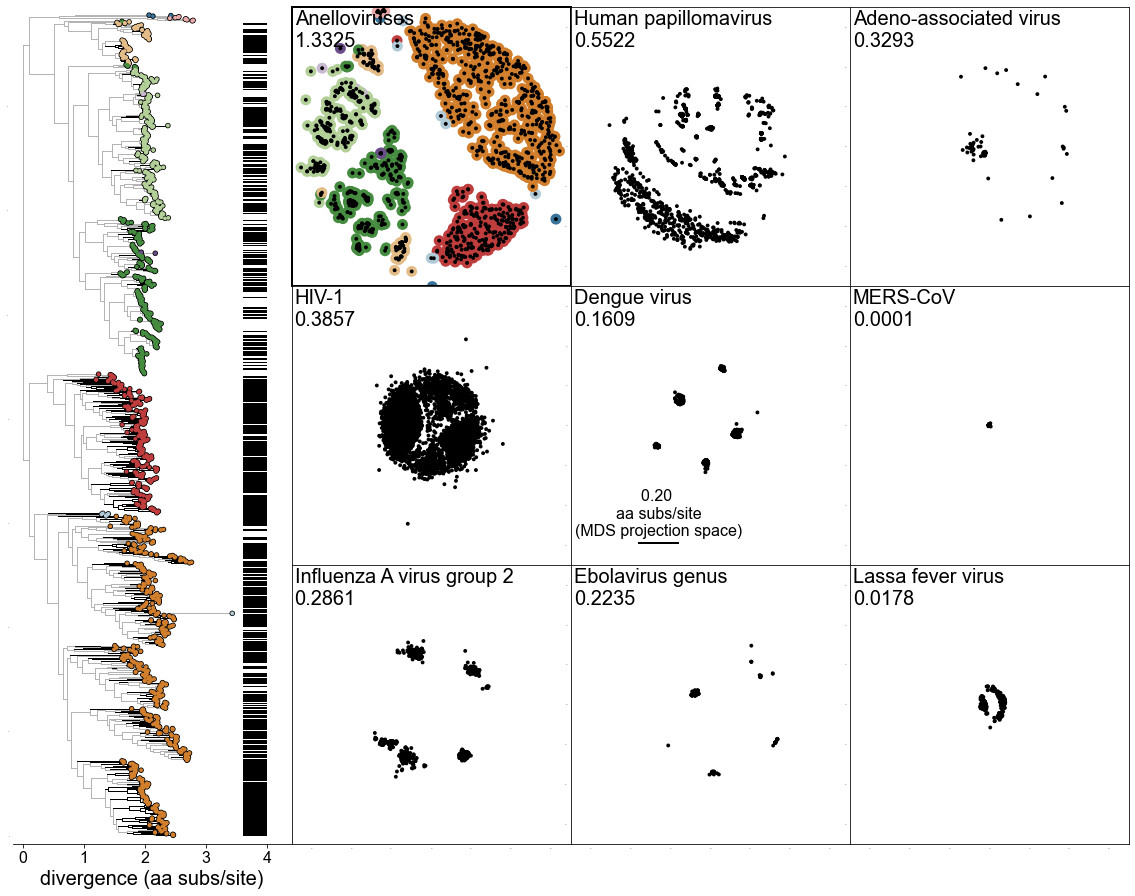

In [4]:
fig = plt.figure(figsize=(20, 15.4),facecolor='w') 
gs = gridspec.GridSpec(3,4,wspace=0.001,hspace=0.0) 

grid_layout=[['Anellos','HPV','AAV'], 
             ['HIV1','Dengue','MERS'], 
             ['IAVgroup2','Ebolavirus','Lassa']]

rename={'Anellos': 'Anelloviruses', 
        'HPV': 'Human papillomavirus', 
        'AAV': 'Adeno-associated virus', 
        'HIV1': 'HIV-1', 
        'Dengue': 'Dengue virus', 
        'MERS': 'MERS-CoV', 
        'IAVgroup2': 'Influenza A virus group 2', 
        'Ebolavirus': 'Ebolavirus genus', 
        'Lassa': 'Lassa fever virus'}


for i,row in enumerate(grid_layout):
    for j,vir in enumerate(grid_layout[i]):
        print(vir)
        if vir in seq_names:
            ax=plt.subplot(gs[i,j+1],facecolor='w')

            coordinates=[]
            cs=[]
            for n,name in enumerate(seq_names[vir]):
                x,y=mds_coords[vir][n]
                if vir=='Anellos':
                    cs.append(colours[vir][cluster_labels[name]])
                else:
                    cs.append('k')
                coordinates.append((x,y))
            
            hull = ConvexHull(coordinates)
            sh_poly=Polygon(list(zip(np.array(coordinates)[hull.vertices,0],np.array(coordinates)[hull.vertices,1])))
            
            
            ax.scatter(*zip(*coordinates),s=15,lw=2,facecolor='k',edgecolor='none',alpha=1.0,zorder=2)
    
            if vir=='Anellos':
                ax.scatter(*zip(*coordinates),s=15*8,lw=2,facecolor=cs,edgecolor='none',alpha=1.0,zorder=1)
                [ax.spines[loc].set_linewidth(2) for loc in ax.spines]
                
            ax.text(0.01,0.99,'%s\n%.4f'%(rename[vir],sh_poly.area),size=20,fontweight=100,ha='left',va='top',transform=ax.transAxes)
            print('Convex hull area: %s'%(sh_poly.area))
            
            ax.set_xlim(-0.7,0.7)
            ax.set_ylim(ax.get_xlim())
            ax.tick_params(size=0,labelsize=0)
            ax.set_aspect(1)
            
        if vir=='Dengue':
            x=-0.36
            l=0.2
            y=-0.59
            ax.plot([x,x+l],[y,y],lw=2,color='k')
            ax.text(x+l/2,y+0.02,'%.2f \naa subs/site\n(MDS projection space)'%(l),va='bottom',ha='center',size=16)
            
ax=plt.subplot(gs[:,0])  
    
c_func=lambda k: tree_colour[k.name]
ll=trees['Anellos']

for k in ll.getExternal():
    if is_study[k.name]==False:
        cur_node=k
        while cur_node:
            cur_node.traits['background']=True
            cur_node=cur_node.parent
        fc='grey'
    else:
        fc='k'
    w=0.4
    
    rec=study_recipient.match(k.name)
    don=study_donor.match(k.name)
    
    if rec or don:
        which=rec.group(1) if rec else don.group(1)
        ax.add_patch(Rectangle((ll.treeHeight*1.05,k.y-0.5),w,1,facecolor='k',edgecolor='none'))

branch_colour=lambda k: '#B4B4B4' if 'background' in k.traits and k.traits['background']==True else 'k'
ll.plotTree(ax,colour=branch_colour,width=1)
ll.plotPoints(ax,colour=lambda k: colours['Anellos'][cluster_labels[k.name]],size=15)

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_xlim(-ll.treeHeight*0.05,ll.treeHeight*1.05+w*2)
ax.set_ylim(-0.01*ll.ySpan,ll.ySpan*1.01)

ax.tick_params(axis='y',size=0,labelsize=0)
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]
ax.set_xlabel('divergence (aa subs/site)',size=20)

ax.tick_params(axis='x',labelsize=16)

plt.savefig('/Users/evogytis/Downloads/virus-MDS.pdf',dpi=300,bbox_inches='tight')

plt.show()